In [29]:
import numpy as np
import pandas as pd
import h5py
import pyute as ut
from importlib import reload
reload(ut)
import pdb
import matplotlib.pyplot as plt
import nub_utils as utils
reload(utils)
import sklearn
import nub_figures as nf
%matplotlib notebook

In [30]:
dsname = '/Users/dan/Documents/notebooks/mossing-PC/shared_data/evan_nub_data_struct_l4.hdf5'

In [31]:
with ut.hdf5read(dsname) as ds:
    keylist = list(ds.keys())
    print(ds[keylist[0]]['nub_0']['F'].shape)
    print(ds[keylist[0]]['nub_0']['decon'].shape)

(320, 662, 55)
(320, 662, 55)


In [32]:
reload(ut)
df, roi_info, trial_info = ut.compute_tavg_dataframe(dsname,'nub_0',datafield='decon')

<HDF5 group "/session_evan_7734_308" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']
<HDF5 group "/session_evan_7734_338" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']
<HDF5 group "/session_evan_7736_265" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']
<HDF5 group "/session_evan_7736_300" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']
<HDF5 group "/session_evan_7737_291" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']
<HDF5 group "/session_evan_7737_326" (6 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_type', 'mouse_id', 'nub_0']


In [33]:
keylist = list(roi_info.keys())

In [34]:
def select_trials(trial_info,selector,training_frac):
    # dict saying what to do with each trial type. If a function, apply that function to the trial info column to 
    # obtain a boolean indexing variable
    # if 0, then the tuning output should be indexed by that variable
    # if 1, then that variable will be marginalized over in the tuning output
    ntrials = {}
    params = list(selector.keys())
    train_test = {}
    for key in trial_info.keys():
        ntrials[key] = trial_info[key][params[0]].size
        gd = np.ones((ntrials[key],),dtype='bool')
        for param in params:
            if callable(selector[param]):
                exclude = ~selector[param](trial_info[key][param])
                gd[exclude] = False
        condition_list = gen_condition_list(trial_info[key],selector)
        condition_list = [c[gd] for c in condition_list]
        in_training_set = np.zeros((ntrials[key],),dtype='bool')
        in_test_set = np.zeros((ntrials[key],),dtype='bool')
        to_keep = output_training_test(condition_list,training_frac)
        in_training_set[gd] = to_keep
        in_test_set[gd] = ~to_keep
        train_test[key] = [in_training_set,in_test_set]
    return train_test

In [35]:
def output_training_test(condition_list,training_frac):
    # output training and test sets balanced for conditions
    if not isinstance(condition_list,list):
        condition_list = [condition_list.copy()]
    iconds,uconds = zip(*[pd.factorize(c,sort=True) for c in condition_list])
    #uconds = [np.sort(u) for u in uconds]
    nconds = np.array([u.size for u in uconds])
    in_training_set = np.zeros(condition_list[0].shape,dtype='bool')
    for iflat in range(np.prod(nconds)):
        coords = np.unravel_index(iflat,tuple(nconds))
        lkat = np.where(ut.k_and(*[iconds[ic] == coords[ic] for ic in range(len(condition_list))]))[0]
        n_train = int(np.round(training_frac*len(lkat)))
        to_train = np.random.choice(lkat,n_train,replace=False)
        in_training_set[to_train] = True
    #assert(True==False)
    return in_training_set

In [36]:
def gen_nub_selector():
    selector = {}
    selector['running'] = lambda x: x
#     selector['stimulus_size'] = lambda x: x==10
#     selector['stimulus_direction_deg'] = 1
    selector['stimulus_nubs_active'] = 0
    return selector

In [37]:
def compute_tuning(df,trial_info,selector,include=None):
    params = list(selector.keys())
    expts = list(trial_info.keys())
    nexpt = len(expts)
    tuning = [None for iexpt in range(nexpt)]
    if include is None:
        include = [None for iexpt in range(nexpt)]
    for iexpt,expt in enumerate(expts):
        in_this_expt = (df.session_id == expt)
        trialwise = df[in_this_expt].pivot(values='data',index='roi_index',columns='trial_index')
        nroi = trialwise.shape[0]
        if include[iexpt] is None:
            include[iexpt] = np.ones((nroi,),dtype='bool')
        if not isinstance(include[iexpt],list):
            include[iexpt] = [include[iexpt]]
        npart = len(include[expt])
        if isinstance(include[expt],list):
            tuning[iexpt] = [None for ipart in range(npart)]
        condition_list = []
        condition_list = gen_condition_list(trial_info[expt],selector,filter_selector=np.logical_not)
        iconds,uconds = zip(*[pd.factorize(c,sort=True) for c in condition_list])
        nconds = [len(u) for u in uconds]
        for ipart in range(npart):
            tuning[iexpt][ipart] = np.zeros((nroi,)+tuple(nconds))
            for iflat in range(np.prod(nconds)):
                coords = np.unravel_index(iflat,tuple(nconds))
                lkat = ut.k_and(include[expt][ipart],*[iconds == coords[ic] for ic in range(len(condition_list))])[0]
                tuning[iexpt][ipart][(slice(None),)+coords] = np.nanmean(trialwise.iloc[:,lkat],-1)
    return tuning

In [38]:
def compute_bootstrap_error(df,trial_info,selector,pct=(16,84),include=None):
    params = list(selector.keys())
    expts = list(trial_info.keys())
    nexpt = len(expts)
    bounds = [None for iexpt in range(nexpt)]
    npct = len(pct)
    if include is None:
        include = [None for iexpt in range(nexpt)]
    for iexpt,expt in enumerate(expts):
        in_this_expt = (df.session_id == expt)
        trialwise = np.array(df[in_this_expt].pivot(values='data',index='roi_index',columns='trial_index'))
        nroi = trialwise.shape[0]
        if include[iexpt] is None:
            include[iexpt] = np.ones((nroi,),dtype='bool')
        if not isinstance(include[iexpt],list):
            include[iexpt] = [include[iexpt]]
        npart = len(include[iexpt])
        bounds[iexpt] = [None for ipart in range(npart)]
        condition_list = []
        condition_list = gen_condition_list(trial_info[expt],selector,filter_selector=np.logical_not)
        iconds,uconds = zip(*[pd.factorize(c,sort=True) for c in condition_list])
        nconds = [len(u) for u in uconds]
        for ipart in range(npart):
            for ipct in range(npct):
                bounds[iexpt][ipart][ipct] = np.zeros((nroi,)+tuple(nconds))
            for iflat in range(np.prod(nconds)):
                coords = np.unravel_index(iflat,tuple(nconds))
                lkat = ut.k_and(include[expt][ipart],*[iconds == coords[ic] for ic in range(len(condition_list))])[0]
                bds = ut.bootstrap(trialwise[:,lkat],np.nanmean,axis=1,pct=pct)
                for ipct in range(npct):
                    bounds[iexpt][ipart][ipct][(slice(None),)+coords] = bds[ipct]
    return bounds

In [39]:
def gen_condition_list(ti,selector,filter_selector=lambda x:True):
    params = list(selector.keys())
    condition_list = []
    for param in params:
        if not callable(selector[param]) and filter_selector(selector[param]):
            condition_list.append(ti[param])
    return condition_list

In [40]:
selector = gen_nub_selector()
train_test = select_trials(trial_info,selector,0.5)

In [41]:
tuning = utils.compute_tuning(df,trial_info,selector,include=train_test)

In [42]:
reload(utils)
bounds = utils.compute_bootstrap_error(df,trial_info,selector,pct=(2.5,97.5,50))
bounds_train_test = utils.compute_bootstrap_error(df,trial_info,selector,pct=(2.5,97.5,50),include=train_test)

In [43]:
bounds[1][2][0]

array([0.02667643, 0.00878111, 0.01377973, 0.0081855 , 0.00202639,
       0.00724969, 0.00146702, 0.00339868, 0.0010931 , 0.00289742,
       0.00707657, 0.00383407, 0.00365786, 0.00181025, 0.00351353,
       0.00182275, 0.00302834, 0.00473174, 0.00281899, 0.00793451,
       0.00631218, 0.00380278, 0.00378417, 0.00830206, 0.00332942,
       0.00348206, 0.00386432, 0.00881845, 0.01553106, 0.004971  ,
       0.00616985, 0.01043178])

In [44]:
plt.figure(figsize=(10,16))
iexpt = 0
for ind in range(40):
    plt.subplot(8,5,ind+1)
    plt.plot(tuning[iexpt][0][ind])
    plt.plot(tuning[iexpt][1][ind])
    plt.axis('off')

<IPython.core.display.Javascript object>

In [45]:
plt.figure(figsize=(10,16))
iexpt = 0
ipart = 0
for ind in range(40):
    plt.subplot(8,5,ind+1)
    plt.plot(np.arange(32),bounds_train_test[iexpt][ipart][2][ind])
    plt.fill_between(np.arange(32),bounds_train_test[iexpt][ipart][0][ind],bounds_train_test[iexpt][ipart][1][ind],alpha=0.4)
    plt.axis('off')

<IPython.core.display.Javascript object>

In [46]:
plt.figure(figsize=(10,16))
iexpt = 0
for ind in range(40):
    plt.subplot(8,5,ind+1)
    plt.plot(np.arange(32),bounds[iexpt][2][ind])
    plt.fill_between(np.arange(32),bounds[iexpt][0][ind],bounds[iexpt][1][ind],alpha=0.4)
    plt.axis('off')

<IPython.core.display.Javascript object>

In [47]:
# reload(utils)
# thetastar = [None for iexpt in range(len(tuning))]
# for iexpt in range(len(tuning)):
#     thetastar[iexpt] = [None for iroi in range(tuning[iexpt][0].shape[0])]
#     for iroi in range(tuning[iexpt][0].shape[0]):
#         print(iroi)
#         thetastar[iexpt][iroi] = utils.fit_output(tuning[iexpt][0][iroi],fn=utils.requ)

In [48]:
reload(utils)
thetastar_mt = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    thetastar_mt[iexpt] = [None for iroi in range(tuning[iexpt][0].shape[0])]
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        thetastar_mt[iexpt][iroi] = utils.fit_output_amplitude(tuning[iexpt][0][iroi],fn=utils.f_mt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


In [49]:
reload(utils)
thetastar_mt_all = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    thetastar_mt_all[iexpt] = [None for iroi in range(tuning[iexpt][0].shape[0])]
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        #y = 0.5*(tuning[iexpt][0][iroi]+tuning[iexpt][1][iroi])
        y = bounds[iexpt][2][iroi].copy()
        thetastar_mt_all[iexpt][iroi] = utils.fit_output_amplitude(y,fn=utils.f_mt,lpoisson=10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


In [50]:
def run_roiwise_fn(fn,inp):
    outp = [None for iexpt in range(len(inp))]
    for iexpt in range(len(inp)):
        nroi = len(inp[iexpt])
        iroi = 0
        temp = fn(inp[iexpt][iroi])
        outp[iexpt] = np.zeros((nroi,temp.shape[0]))
        for iroi in range(nroi):
            print(iroi)
            outp[iexpt][iroi] = fn(inp[iexpt][iroi])
    return outp

In [51]:
reload(utils)
predicted_tuning_mt = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    predicted_tuning_mt[iexpt] = np.zeros_like(tuning[iexpt][1])
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        predicted_tuning_mt[iexpt][iroi] = utils.predict_output_theta_amplitude(thetastar_mt[iexpt][iroi][0],fn=utils.f_mt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [52]:
# reload(utils)
# fn = lambda x: utils.predict_output_theta_amplitude(x[0],fn=utils.f_mt)
# inp = thetastar_mt_all
# predicted_tuning_mt_all = run_roiwise_fn(fn,inp)

In [53]:
# plt.figure()
# for iroi in range(20):
#     plt.subplot(4,5,iroi+1)
#     plt.scatter(tuning[iexpt][1][iroi],predicted_tuning[iexpt][iroi])
#     plt.plot(tuning[iexpt][1][iroi],tuning[iexpt][1][iroi],c='r')
#     plt.axis('off')

In [54]:
iroi = 0
rtest = [None for iexpt in range(len(tuning))]
rtrain = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    nroi = tuning[iexpt][1].shape[0]
    rtest[iexpt] = np.zeros((nroi,))
    rtrain[iexpt] = np.zeros((nroi,))
    for iroi in range(nroi):
        rtest[iexpt][iroi] = np.corrcoef(tuning[iexpt][1][iroi].flatten(),predicted_tuning_mt[iexpt][iroi].flatten())[0,1]
        rtrain[iexpt][iroi] = np.corrcoef(tuning[iexpt][0][iroi].flatten(),predicted_tuning_mt[iexpt][iroi].flatten())[0,1]
rtest = np.concatenate(rtest)
rtrain = np.concatenate(rtrain)

In [55]:
tuning[iexpt][1][iroi].flatten()

array([1.78065439e-03, 4.81545653e-04, 3.21150354e-02, 1.46019259e-02,
       2.31119109e-04, 6.07955914e-05, 3.79429812e-03, 3.76558685e-03,
       9.42513792e-04, 3.18397861e-04, 4.05209423e-03, 3.24933985e-03,
       1.89535616e-03, 1.13234478e-03, 4.38896765e-03, 1.17078941e-02,
       7.86667420e-03, 2.84603324e-03, 2.37054145e-02, 2.03618186e-02,
       3.89450511e-03, 1.78095594e-03, 1.46581553e-03, 5.14300627e-04,
       6.34569565e-03, 3.71805347e-03, 2.07000804e-02, 8.50450906e-03,
       1.86906670e-03, 2.08556619e-03, 1.44646266e-03, 1.58636916e-02])

In [56]:
nexpt = len(tuning)
theta = [None for iexpt in range(nexpt)]
for iexpt in range(nexpt):
    nroi = tuning[iexpt][1].shape[0]
    theta[iexpt] = np.array([thetastar_mt_all[iexpt][iroi][0] for iroi in range(nroi)])

In [57]:
plt.figure()
plt.hist(rtrain,bins=np.linspace(-0.5,1,100),alpha=0.5,label='R$^2$ train')
plt.hist(rtest,bins=np.linspace(-0.5,1,100),alpha=0.5,label='R$^2$ test')
plt.xlabel('R$^2$')
plt.ylabel('# of neurons')
plt.legend()
# plt.savefig('figures/r2_train_test_s1_l4.pdf')

<IPython.core.display.Javascript object>

In [58]:
# for ikey in range(4):
#     plt.figure(figsize=(10,5))
#     ctr = roi_info[keylist[ikey]]['cell_center']
#     displacement = roi_info[keylist[ikey]]['rf_displacement']
#     pval = roi_info[keylist[ikey]]['pval']
#     lkat = pval < 0.05
#     plt.subplot(1,2,1)
#     plt.scatter(ctr[1][lkat],ctr[0][lkat],c=displacement[0][lkat],s=20)
#     plt.subplot(1,2,2)
#     plt.scatter(ctr[1][lkat],ctr[0][lkat],c=displacement[1][lkat],s=20)

In [59]:
# for ikey in range(4):
#     plt.figure(figsize=(10,5))
#     ctr = roi_info[keylist[ikey]]['cell_center']
#     displacement = roi_info[keylist[ikey]]['rf_displacement']
#     pval = roi_info[keylist[ikey]]['pval']
#     lkat = rtest[ikey]>0.25 #np.ones(pval.shape,dtype='bool')
#     plt.subplot(1,2,1)
#     plt.scatter(ctr[1][lkat],ctr[0][lkat],c=theta[ikey][lkat,-1],s=20)
#     plt.subplot(1,2,2)
#     plt.scatter(ctr[1][lkat],ctr[0][lkat],c=np.argmax(theta[ikey][lkat,:-1],axis=1),s=20)

In [60]:
#     with h5py.File(dsname,mode='r') as ds:
#         misplacement = [None for ikey in range(len(keylist))]
#         displacement = [None for ikey in range(len(keylist))]
#         for ikey in range(len(keylist)):
#             X = ds[keylist[ikey]]['cell_center'][:]
#             y = ds[keylist[ikey]]['nub_0']['rf_displacement_deg'][:].T
#             linreg = sklearn.linear_model.LinearRegression().fit(X,y)
#             misplacement[ikey] = y-linreg.predict(X)
#             displacement[ikey] = y

In [61]:
# for iexpt in range(4):
#     plt.figure()
#     pval = roi_info[keylist[iexpt]]['pval']
#     lkat = np.logical_and(rtest[iexpt]>0.25,pval<0.05)
#     plt.scatter(np.sqrt((misplacement[iexpt][lkat]**2).sum(1)),theta[iexpt][lkat,1])

In [62]:
# plt.figure(figsize=(6,3))
# reload(utils)
# ut.mkdir('figures/glm_fits')
# for iexpt in range(nexpt):
#     ut.mkdir('figures/glm_fits/expt%d'%iexpt)
#     for ind in range(theta[iexpt].shape[0]):
#         #plt.subplot(8,5,ind+1)
#         plt.clf()
#         plt.subplot(1,2,1)
#         plt.plot(np.arange(32),bounds[iexpt][2][ind],label='data')
#         plt.fill_between(np.arange(32),bounds[iexpt][0][ind],bounds[iexpt][1][ind],alpha=0.25)
#         plt.xticks([])
#         plt.yticks([])
#         plt.plot(np.arange(32),predicted_tuning[iexpt][ind],label='model')
#         plt.legend()
#         plt.title('Tuning curve')
#         plt.ylabel('event rate (a.u.)')
#         plt.xlabel('stimulus #')
#         plt.subplot(1,2,2)
#         utils.show_fit(theta[iexpt][ind])
#         plt.title('GLM fit parameters')
#         plt.savefig('figures/glm_fits/expt%d/roi%04d.pdf'%(iexpt,ind))

In [63]:
# def reorder_stims(nub_ordering,flipped=None,nub_var=utils.nubs_active):
#     if flipped is None:
#         flipped = np.zeros(nub_ordering.shape,dtype='bool')
#     nnub = utils.nubs_active.shape[1]
#     ordering = np.arange(32).reshape(tuple([2]*nnub))
#     for inub in range(len(nub_ordering)):
#         if flipped[inub]:
#             ordering = np.flip(ordering,axis=inub)
#     ordering = ordering.transpose(tuple(nub_ordering)).flatten()
#     return ordering

In [64]:
def reorder_stims(nub_ordering,flipped=None,nub_var=utils.nubs_active):
    if flipped is None:
        flipped = np.zeros(nub_ordering.shape,dtype='bool')
    nnub = nub_var.shape[1]
    binary_vals = nub_var.copy()
    for inub in range(len(nub_ordering)):
        if flipped[inub]:
            binary_vals[:,inub] = ~binary_vals[:,inub]
    binary_vals = binary_vals[:,list(nub_ordering)]
    multby = np.array([2**inub for inub in range(nnub)][::-1])[np.newaxis,:]
    ordering = np.argsort((multby*binary_vals).sum(1))
    return ordering

In [65]:
def show_reordered_plot_and_fit(this_bounds,this_theta,cbd=1,nub_var=utils.nubs_active):
    #this_bounds = [bounds[iexpt][ibd][ind] for ibd in range(3)]
    this_prediction = utils.predict_output_theta_amplitude(this_theta,fn=utils.f_mt,nub_var=nub_var)
    
    flipped = this_theta[:-2] < 0
    nub_ordering = np.argsort(np.abs(this_theta[:-2]))[::-1]
    stim_ordering = reorder_stims(nub_ordering,flipped=flipped,nub_var=nub_var)
    
    #plt.subplot(8,5,ind+1)
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(np.arange(2**nnub),this_bounds[2][stim_ordering],label='data')
    plt.fill_between(np.arange(2**nnub),this_bounds[0][stim_ordering],this_bounds[1][stim_ordering],alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.plot(np.arange(2**nnub),this_prediction[stim_ordering],label='model')
    plt.legend()
    plt.title('Tuning curve')
    plt.ylabel('event rate (a.u.)')
    signs = [] #'' for inub in range(len(flipped))]
    for inub in range(len(nub_ordering)):
        if flipped[nub_ordering[inub]]:
            signs.append('-')
        else:
            signs.append('+')
    markers = ','.join([s+str(n) for s,n in zip(signs,nub_ordering)])
    plt.xlabel('stimulus # (ordered [' + markers + '])')
    plt.subplot(1,2,2)
    utils.show_fit(this_theta,cbd=cbd)
    plt.title('GLM fit parameters')

In [66]:
def show_plot_reordered_plot_and_fit(this_bounds,this_theta,cbd=1,nub_var=utils.nubs_active):
    #this_bounds = [bounds[iexpt][ibd][ind] for ibd in range(3)]
    this_prediction = utils.predict_output_theta_amplitude(this_theta,fn=utils.f_mt,nub_var=nub_var)
    
    flipped = this_theta[:-2] < 0
    nub_ordering = np.argsort(np.abs(this_theta[:-2]))[::-1]
    stim_ordering = reorder_stims(nub_ordering,flipped=flipped,nub_var=nub_var)
    
    #plt.subplot(8,5,ind+1)
    plt.clf()
    plt.subplot(1,3,1)
    this_expanded_bounds = [[tb[np.newaxis] for tb in this_bounds]]
    nf.plot_example_tuning_curves_(this_expanded_bounds,[0],[0],isolated=False)
#     plt.plot(np.arange(2**nnub),this_bounds[2],label='data')
#     plt.fill_between(np.arange(2**nnub),this_bounds[0],this_bounds[1],alpha=0.25)
#     plt.xticks([])
#     plt.yticks([])
# #     plt.plot(np.arange(2**nnub),this_prediction,label='model')
#     plt.legend()
    plt.title('Tuning curve')
    plt.ylabel('event rate (a.u.)')
    plt.subplot(1,3,3)
    plt.plot(np.arange(2**nnub),this_bounds[2][stim_ordering],label='data')
    plt.fill_between(np.arange(2**nnub),this_bounds[0][stim_ordering],this_bounds[1][stim_ordering],alpha=0.25)
    plt.xticks([])
    plt.yticks([])
    plt.plot(np.arange(2**nnub),this_prediction[stim_ordering],label='model')
    plt.legend()
    plt.title('Reordered tuning curve')
    plt.ylabel('event rate (a.u.)')
    signs = [] #'' for inub in range(len(flipped))]
    for inub in range(len(nub_ordering)):
        if flipped[nub_ordering[inub]]:
            signs.append('-')
        else:
            signs.append('+')
    ut.erase_top_right()
    markers = ','.join([s+str(n) for s,n in zip(signs,nub_ordering)])
    plt.xlabel('stimulus # (ordered [' + markers + '])')
    plt.subplot(1,3,2)
    utils.show_fit(this_theta,cbd=cbd)
    plt.title('GLM fit parameters')

<IPython.core.display.Javascript object>


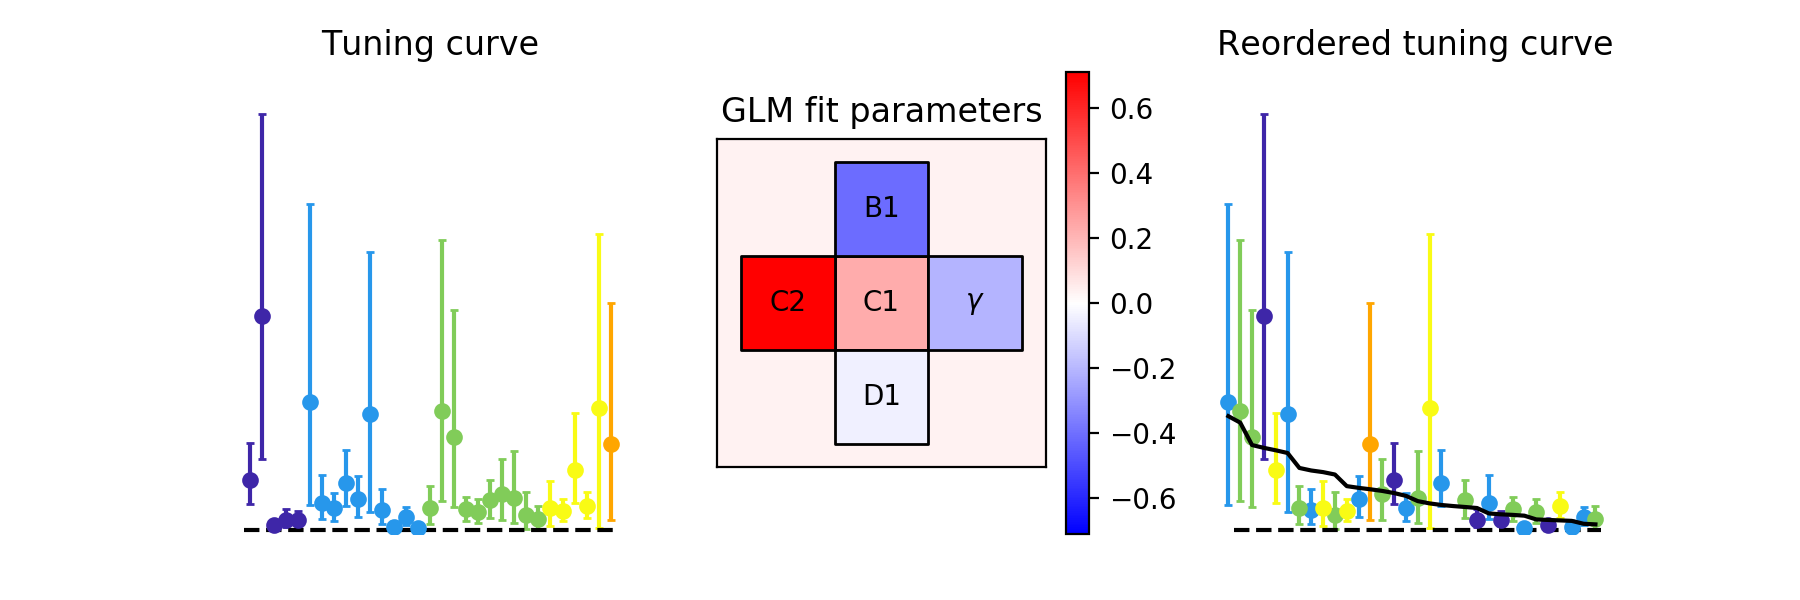

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


In [118]:
nnub = 5
plt.figure(figsize=(9,3))
reload(utils)
reload(nf)
# foldname = 'figures/glm_fits_mt_reordered_s1_l4'
foldname = 'figures/glm_fits_mt_ordered_reordered_s1_l4'
ut.mkdir(foldname)
for iexpt in range(nexpt):
    ut.mkdir(foldname+'/expt%d'%iexpt)
    for ind in range(len(thetastar_mt_all[iexpt])):
        print(ind)
        this_theta = thetastar_mt_all[iexpt][ind][0]
        this_bounds = [bounds[iexpt][ibd][ind] for ibd in range(3)]
#         show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())
        nf.show_plot_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max(),rank_order=True,s1=True)
        
        #this_prediction = predicted_tuning_mt_all[iexpt][ind]okjli
        #flipped = this_theta[:-2] < 0
        #nub_ordering = np.argsort(np.abs(this_theta[:-2]))[::-1]
        #stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
        ##plt.subplot(8,5,ind+1)
        #plt.clf()
        #plt.subplot(1,2,1)
        #plt.plot(np.arange(32),bounds[iexpt][2][ind][stim_ordering],label='data')
        #plt.fill_between(np.arange(32),bounds[iexpt][0][ind][stim_ordering],bounds[iexpt][1][ind][stim_ordering],alpha=0.25)
        #plt.xticks([])
        #plt.yticks([])
        #plt.plot(np.arange(32),this_prediction[stim_ordering],label='model')
        #plt.legend()
        #plt.title('Tuning curve')
        #plt.ylabel('event rate (a.u.)')
        #signs = [] #'' for inub in range(len(flipped))]
        #for inub in range(len(nub_ordering)):
        #    if flipped[nub_ordering[inub]]:
        #        signs.append('-')
        #    else:
        #        signs.append('+')
        #markers = ','.join([s+str(n) for s,n in zip(signs,nub_ordering)])
        #plt.xlabel('stimulus # (ordered [' + markers + '])')
        #plt.subplot(1,2,2)
        #utils.show_fit(this_theta)
        #plt.title('GLM fit parameters')
        plt.savefig(foldname+'/expt%d/roi%04d.pdf'%(iexpt,ind))

In [95]:
iroi = 0
rtest = [None for iexpt in range(len(tuning))]
rtrain = [None for iexpt in range(len(tuning))]
roracle = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    nroi = tuning[iexpt][1].shape[0]
    rtest[iexpt] = np.zeros((nroi,))
    rtrain[iexpt] = np.zeros((nroi,))
    roracle[iexpt] = np.zeros((nroi,))
    for iroi in range(nroi):
        rtest[iexpt][iroi] = np.corrcoef(tuning[iexpt][1][iroi].flatten(),predicted_tuning_mt[iexpt][iroi].flatten())[0,1]
        rtrain[iexpt][iroi] = np.corrcoef(tuning[iexpt][0][iroi].flatten(),predicted_tuning_mt[iexpt][iroi].flatten())[0,1]
        roracle[iexpt][iroi] = np.corrcoef(tuning[iexpt][0][iroi].flatten(),tuning[iexpt][1][iroi].flatten())[0,1]
rtest_lin = np.concatenate(rtest)
rtrain_lin = np.concatenate(rtrain)
roracle_lin = np.concatenate(roracle)

In [98]:
import scipy.stats as sst
lkat = (roracle_lin>0.5)
sst.wilcoxon(rtest_lin[lkat]-roracle_lin[lkat])

WilcoxonResult(statistic=95374.0, pvalue=9.126309272089667e-45)

In [ ]:
cutoff = 3
eligible_combos = [None for iexpt in range(nexpt)]
ipart = 0
for iexpt in range(nexpt):
    nroi = len(thetastar_mt[iexpt])
    eligible_combos[iexpt] = np.zeros((nroi,nnub,nnub),dtype='bool')
    for iroi in range(nroi):
        
        this_theta = thetastar_mt[iexpt][iroi][0]
        thisy = [bounds_train_test[iexpt][ipart][ibd][iroi] for ibd in range(3)].copy()
        yres = [y - utils.predict_output_theta_amplitude(this_theta,fn=utils.f_mt) for y in thisy]
        
        for i1 in range(nnub):
            lkats1 = [utils.nubs_active[:,i1]==ibin for ibin in range(2)]
            for i2 in range(i1+1,nnub):
                lkats2 = [utils.nubs_active[:,i2]==ibin for ibin in range(2)]
                sigdiff = np.zeros((2,2))
                for ibin1 in range(2):
                    for ibin2 in range(2):
                        lkat = lkats1[ibin1] & lkats2[ibin2]
                        sigma = 0.25*(yres[1][lkat]-yres[0][lkat]) #std is 0.25 of 95 pct confidence range
                        mu = yres[2][lkat]
                        sigdiff[ibin1,ibin2] = ((mu/sigma).sum())
                nlkat = (2**nnub)/4
                eligible_combos[iexpt][iroi,i1,i2] = np.abs((sigdiff*np.array(((1,-1),(-1,1)))).sum())>cutoff*nlkat

In [42]:
reload(utils)
thetastar_mt_nonlin = [None for iexpt in range(len(tuning))]
ipart = 0
for iexpt in range(len(tuning)):
    thetastar_mt_nonlin[iexpt] = [None for iroi in range(tuning[iexpt][0].shape[0])]
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        this_theta = thetastar_mt[iexpt][iroi][0]
        combos = np.where(eligible_combos[iexpt][iroi])
        gate_val = np.array([utils.nubs_active[:,ia]&utils.nubs_active[:,ib] for ia,ib in zip(*combos)]).T
        if not gate_val.size:
            gate_val = np.zeros((utils.nubs_active.shape[0],0),dtype='bool')
        nub_extra = np.concatenate((utils.nubs_active,gate_val),axis=1)
        y = bounds[iexpt][2][iroi].copy()
        new_theta = np.concatenate((this_theta[:5],np.zeros((gate_val.shape[1],)),this_theta[5:]))
        bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
        thetastar_mt_nonlin[iexpt][iroi] = utils.fit_output_amplitude(bounds_train_test[iexpt][ipart][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


In [43]:
reload(utils)
thetastar_mt_nonlin_all = [None for iexpt in range(len(tuning))]
ipart = 0
for iexpt in range(len(tuning)):
    thetastar_mt_nonlin_all[iexpt] = [None for iroi in range(tuning[iexpt][0].shape[0])]
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        this_theta = thetastar_mt[iexpt][iroi][0]
        combos = np.where(eligible_combos[iexpt][iroi])
        gate_val = np.array([utils.nubs_active[:,ia]&utils.nubs_active[:,ib] for ia,ib in zip(*combos)]).T
        if not gate_val.size:
            gate_val = np.zeros((utils.nubs_active.shape[0],0),dtype='bool')
        nub_extra = np.concatenate((utils.nubs_active,gate_val),axis=1)
        y = bounds[iexpt][2][iroi].copy()
        new_theta = np.concatenate((this_theta[:5],np.zeros((gate_val.shape[1],)),this_theta[5:]))
        bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
        thetastar_mt_nonlin_all[iexpt][iroi] = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


<IPython.core.display.Javascript object>


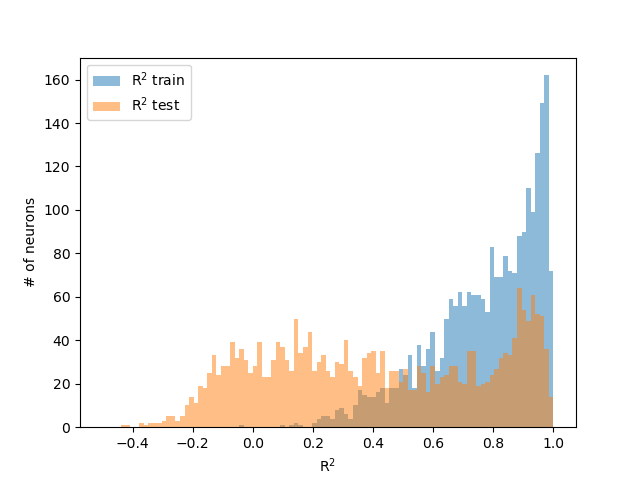

In [44]:
reload(utils)
predicted_tuning_nonlin = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    predicted_tuning_nonlin[iexpt] = np.zeros_like(tuning[iexpt][1])
    for iroi in range(tuning[iexpt][0].shape[0]):
        print(iroi)
        combos = np.where(eligible_combos[iexpt][iroi])
        gate_val = np.array([utils.nubs_active[:,ia]&utils.nubs_active[:,ib] for ia,ib in zip(*combos)]).T
        if not gate_val.size:
            gate_val = np.zeros((utils.nubs_active.shape[0],0),dtype='bool')
        nub_extra = np.concatenate((utils.nubs_active,gate_val),axis=1)
        predicted_tuning_nonlin[iexpt][iroi] = utils.predict_output_theta_amplitude(thetastar_mt_nonlin[iexpt][iroi][0],fn=utils.f_mt,nub_var=nub_extra)

rtest = [None for iexpt in range(len(tuning))]
rtrain = [None for iexpt in range(len(tuning))]
for iexpt in range(len(tuning)):
    nroi = tuning[iexpt][1].shape[0]
    rtest[iexpt] = np.zeros((nroi,))
    rtrain[iexpt] = np.zeros((nroi,))
    for iroi in range(nroi):
        
        rtest[iexpt][iroi] = np.corrcoef(tuning[iexpt][1][iroi].flatten(),predicted_tuning_nonlin[iexpt][iroi].flatten())[0,1]
        rtrain[iexpt][iroi] = np.corrcoef(tuning[iexpt][0][iroi].flatten(),predicted_tuning_nonlin[iexpt][iroi].flatten())[0,1]
rtest = np.concatenate(rtest)
rtrain = np.concatenate(rtrain)

plt.figure()
plt.hist(rtrain,bins=np.linspace(-0.5,1,100),alpha=0.5,label='R$^2$ train')
plt.hist(rtest,bins=np.linspace(-0.5,1,100),alpha=0.5,label='R$^2$ test')
plt.xlabel('R$^2$')
plt.ylabel('# of neurons')
plt.legend()
plt.savefig('figures/r2_train_test_s1_l4_nonlin.pdf')

<IPython.core.display.Javascript object>


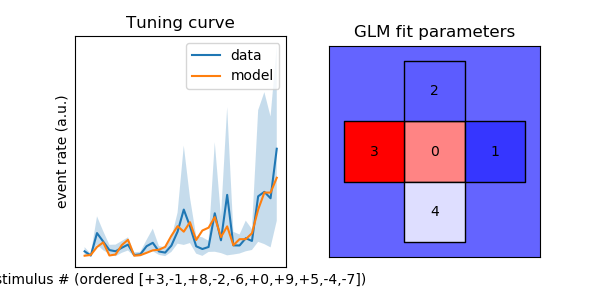

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


In [45]:
nnub = 5
plt.figure(figsize=(6,3))
reload(utils)
foldname = 'figures/glm_fits_nonlinear_reordered_s1_l4'
ut.mkdir(foldname)
for iexpt in range(nexpt):
    ut.mkdir(foldname+'/expt%d'%iexpt)
    for ind in range(len(thetastar_mt_nonlin_all[iexpt])):
        
        print(ind)
        combos = np.where(eligible_combos[iexpt][ind])
        gate_val = np.array([utils.nubs_active[:,ia]&utils.nubs_active[:,ib] for ia,ib in zip(*combos)]).T
        if not gate_val.size:
            gate_val = np.zeros((utils.nubs_active.shape[0],0),dtype='bool')
        nub_extra = np.concatenate((utils.nubs_active,gate_val),axis=1)
        
        this_theta = thetastar_mt_nonlin_all[iexpt][ind][0]
        this_bounds = [bounds[iexpt][ibd][ind] for ibd in range(3)]
        show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max(),nub_var=nub_extra)
        
        #this_prediction = predicted_tuning_mt_all[iexpt][ind]
        #flipped = this_theta[:-2] < 0
        #nub_ordering = np.argsort(np.abs(this_theta[:-2]))[::-1]
        #stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
        ##plt.subplot(8,5,ind+1)
        #plt.clf()
        #plt.subplot(1,2,1)
        #plt.plot(np.arange(32),bounds[iexpt][2][ind][stim_ordering],label='data')
        #plt.fill_between(np.arange(32),bounds[iexpt][0][ind][stim_ordering],bounds[iexpt][1][ind][stim_ordering],alpha=0.25)
        #plt.xticks([])
        #plt.yticks([])
        #plt.plot(np.arange(32),this_prediction[stim_ordering],label='model')
        #plt.legend()
        #plt.title('Tuning curve')
        #plt.ylabel('event rate (a.u.)')
        #signs = [] #'' for inub in range(len(flipped))]
        #for inub in range(len(nub_ordering)):
        #    if flipped[nub_ordering[inub]]:
        #        signs.append('-')
        #    else:
        #        signs.append('+')
        #markers = ','.join([s+str(n) for s,n in zip(signs,nub_ordering)])
        #plt.xlabel('stimulus # (ordered [' + markers + '])')
        #plt.subplot(1,2,2)
        #utils.show_fit(this_theta)
        #plt.title('GLM fit parameters')
        plt.savefig(foldname+'/expt%d/roi%04d.pdf'%(iexpt,ind))

In [ ]:
reload(utils)
iexpt = 0
iroi = 3
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

# which_nubs = np.array([0,2])
# boolean_gate = lambda a,b: (a ^ b)
which_nubs = np.array([0,2,3])
boolean_gate = lambda a,b,c: (a|c)&b #0.5*((a^b) + (c^b))#(a ^ b) & ~c
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,gate_val[:,np.newaxis]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((1,)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:nnub]).max(),nub_var=nub_extra)
flipped = new_theta[:-2] < 0

nub_ordering = np.argsort(np.abs(new_theta[:-2]))[::-1]
stim_ordering = reorder_stims(nub_ordering,flipped=flipped,nub_var=nub_extra)
plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

In [ ]:
reload(utils)
iexpt = 0
iroi = 10
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([3,0,2])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c: a&b
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,gate_val[:,np.newaxis]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((1,)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:nnub]).max(),nub_var=nub_extra)
flipped = this_theta[:-2] < 0

nub_ordering = np.argsort(np.abs(new_theta[:nnub]))[::-1]
stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


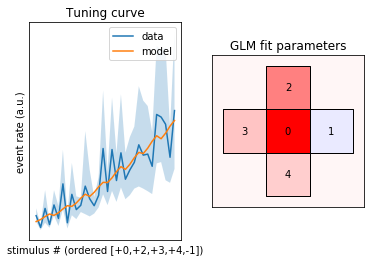

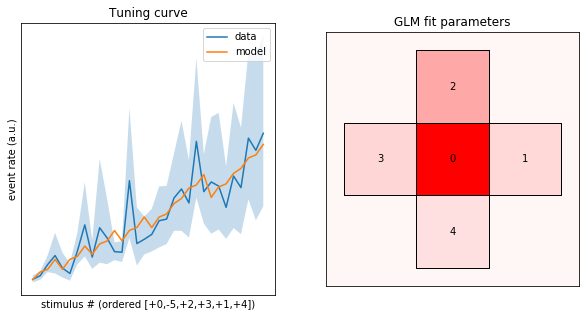

In [308]:
reload(utils)
iexpt = 0
iroi = 18
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([0,1,2,3])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c,d: a&b #+ b^d#+ b^c #
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,gate_val[:,np.newaxis]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((1,)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:nnub]).max(),nub_var=nub_extra)
flipped = this_theta[:-2] < 0

nub_ordering = np.argsort(np.abs(new_theta[:nnub]))[::-1]
stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

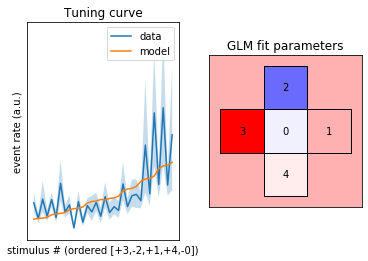

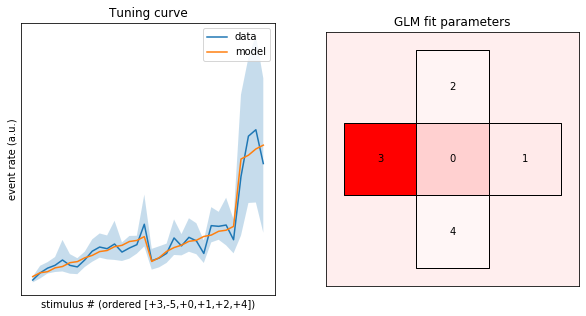

In [307]:
reload(utils)
iexpt = 0
iroi = 60
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

# which_nubs = np.array([3,0,2])
# # boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ ~b) & ~(a & c))
which_nubs = np.array([3,0,2])
boolean_gate = lambda a,b,c: a&(b|c) #a^b + a^c #+ ~(b^c)
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,gate_val[:,np.newaxis]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((1,)),this_theta[5:]))
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:nnub]).max(),nub_var=nub_extra)
# flipped = this_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

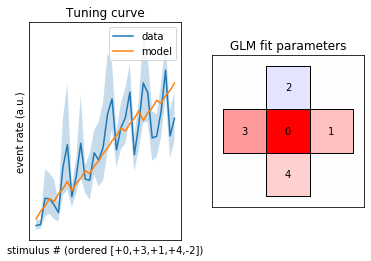

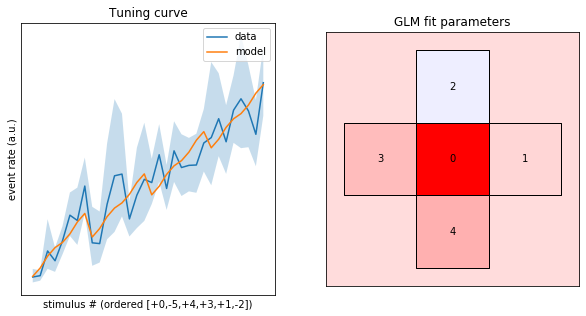

In [306]:
reload(utils)
iexpt = 0
iroi = 75
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([0,4])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b: a&b
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,gate_val[:,np.newaxis]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((1,)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:-2]).max(),nub_var=nub_extra)
# flipped = new_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub+1]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

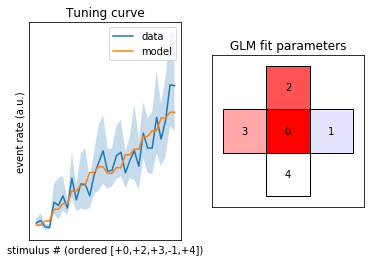

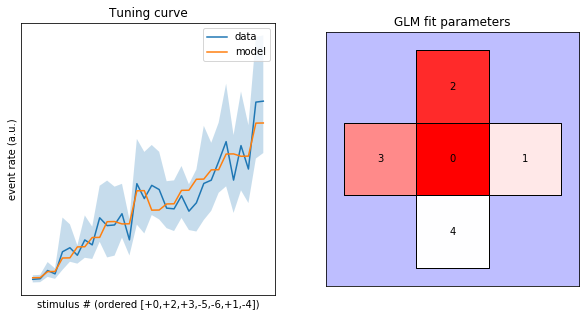

In [321]:
reload(utils)
iexpt = 0
iroi = 81
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([1,2,3])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c: [a&b, a&c]
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,*[x[:,np.newaxis] for x in gate_val]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((len(gate_val),)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:-2]).max(),nub_var=nub_extra)
# flipped = new_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub+1]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

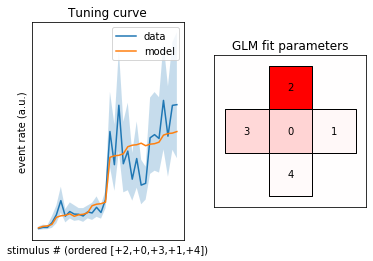

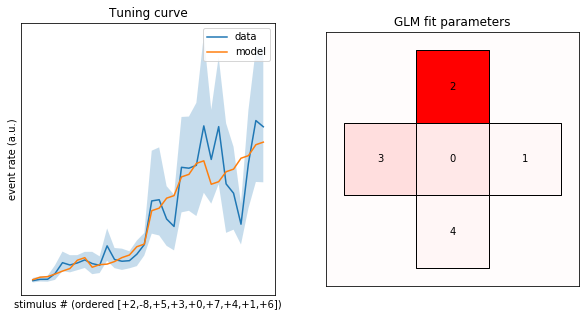

In [329]:
reload(utils)
iexpt = 0
iroi = 82
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([0,2,3,4])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c,d: [a&b,a&c,a&d,b&d]
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,*[x[:,np.newaxis] for x in gate_val]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((len(gate_val),)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:-2]).max(),nub_var=nub_extra)
# flipped = new_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub+1]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

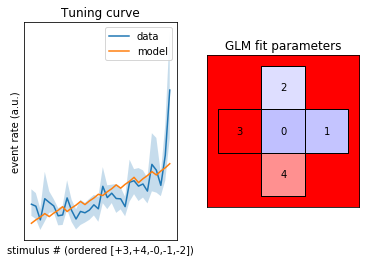

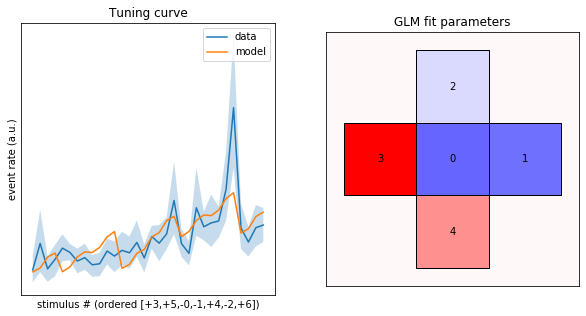

In [59]:
reload(utils)
iexpt = 0
iroi = 291
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([0,1,2])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c: [a&b,a&c]
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,*[x[:,np.newaxis] for x in gate_val]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((len(gate_val),)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:-2]).max(),nub_var=nub_extra)
# flipped = new_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub+1]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

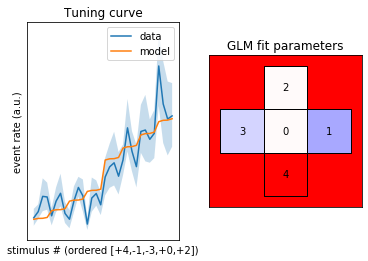

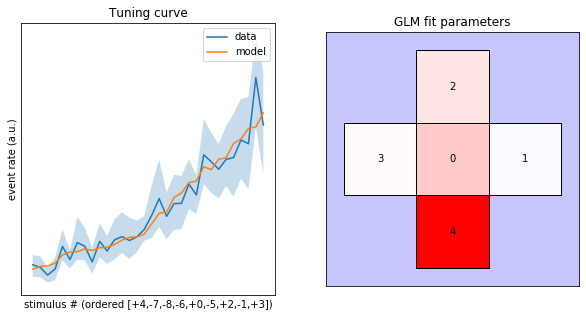

In [53]:
reload(utils)
iexpt = 0
iroi = 342
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
show_reordered_plot_and_fit(this_bounds,this_theta,cbd=np.abs(this_theta[:nnub]).max())

which_nubs = np.array([0,1,2,3,4])
# boolean_gate = lambda a,b,c: (a ^ ~b) & (a ^ c)
# boolean_gate = lambda a,b,c: ~((a ^ b) & ~(a & c))
boolean_gate = lambda a,b,c,d,e: [a&c,a&e,b&e,d&e]
gate_val = boolean_gate(*[utils.nubs_active[:,inub] for inub in which_nubs])
nub_extra = np.concatenate((utils.nubs_active,*[x[:,np.newaxis] for x in gate_val]),axis=1)

new_theta = np.concatenate((this_theta[:5],np.zeros((len(gate_val),)),this_theta[5:]))
# new_theta[0] = 0
# new_theta[3] = 0
# new_theta[7] = 1
bds = [(-np.inf,np.inf) for x in range(new_theta.size-1)] + [(0,1)]
# bds[5:6] = [(0,0) for ibd in range(2)]
# bds[7:9] = [(0,0)]
new_thetastar = utils.fit_output_amplitude(bounds[iexpt][2][iroi],fn=utils.f_mt,theta0=new_theta,lpoisson=10,nub_var=nub_extra,bounds=bds)
new_theta = new_thetastar[0]
plt.figure(figsize=(10,5))

#nub_extra = np.logical_and(utils.nubs_active[])
show_reordered_plot_and_fit(this_bounds,new_theta,cbd=np.abs(new_theta[:-2]).max(),nub_var=nub_extra)
# flipped = new_theta[:-2] < 0

# nub_ordering = np.argsort(np.abs(new_theta[:nnub+1]))[::-1]
# stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
# plt.subplot(1,2,1)


# plt.plot(gate_val[stim_ordering]/10)
#plt.plot(utils.nubs_and[:,8][stim_ordering]/10)

In [63]:
eligible_combos

[array([[[False, False, False,  True, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False,  True, False, False, False],
         [False, False,  True,  True,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        ...,
 
        [[False,  True, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, False, False, False],
       

In [61]:
len(thetastar_mt[iexpt])

997

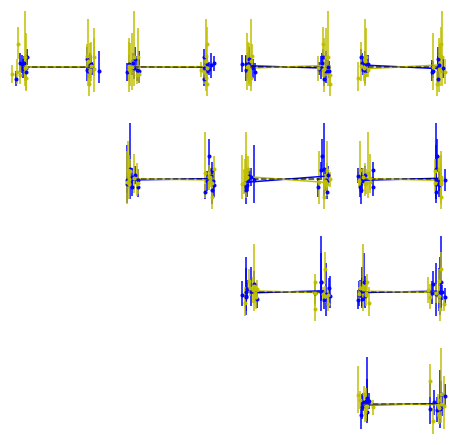

In [54]:
iexpt = 0
iroi = 144
# iroi = 342
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]

thisy = this_bounds.copy()
yres = [y - utils.predict_output_theta_amplitude(this_theta,fn=utils.f_mt) for y in thisy]

plt.figure(figsize=(10,10))
for i1 in range(nnub):
    for i2 in range(i1+1,nnub):
        plt.subplot(nnub,nnub,i1*nnub+i2+1)
        lkats = [utils.nubs_active[:,i1]==ibin for ibin in range(2)]
        colors = ['b','y']
        for ibin in range(2):
            noise = 0.05*np.random.randn(lkats[ibin].sum())
            error = np.concatenate(((yres[2][lkats[ibin]]-yres[0][lkats[ibin]])[np.newaxis],(yres[1][lkats[ibin]]-yres[2][lkats[ibin]])[np.newaxis]),axis=0)
            plt.errorbar(utils.nubs_active[:,i2][lkats[ibin]]+noise,yres[2][lkats[ibin]],yerr=error,fmt='.',c=colors[ibin])
            grps = [yres[2][lkats[ibin]][utils.nubs_active[:,i2][lkats[ibin]]==ibin2].mean() for ibin2 in range(2)]
            plt.plot((0,1),grps,c=colors[ibin])
            plt.plot((0,1),(0,0),linestyle='dashed',c='k',alpha=0.5)
        plt.axis('off')

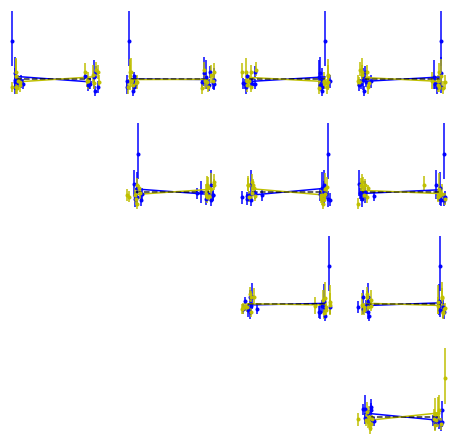

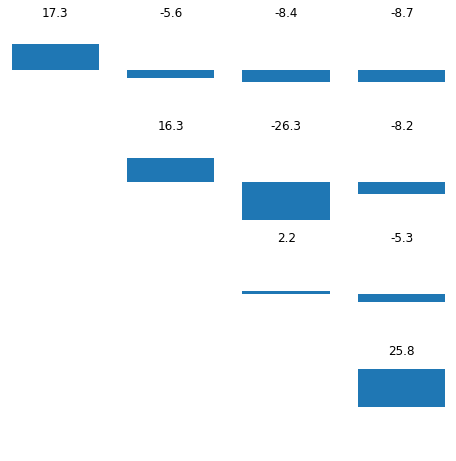

In [60]:
iexpt = 0
iroi = 291
# iroi = 294
# iroi = 342
this_theta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]

thisy = this_bounds.copy()
yres = [y - utils.predict_output_theta_amplitude(this_theta,fn=utils.f_mt) for y in thisy]

plt.figure(figsize=(10,10))
for i1 in range(nnub):
    for i2 in range(i1+1,nnub):
        plt.subplot(nnub,nnub,i1*nnub+i2+1)
        lkats = [utils.nubs_active[:,i1]==ibin for ibin in range(2)]
        colors = ['b','y']
        for ibin in range(2):
            noise = 0.05*np.random.randn(lkats[ibin].sum())
            error = np.concatenate(((yres[2][lkats[ibin]]-yres[0][lkats[ibin]])[np.newaxis],(yres[1][lkats[ibin]]-yres[2][lkats[ibin]])[np.newaxis]),axis=0)
            plt.errorbar(utils.nubs_active[:,i2][lkats[ibin]]+noise,yres[2][lkats[ibin]],yerr=error,fmt='.',c=colors[ibin])
            grps = [yres[2][lkats[ibin]][utils.nubs_active[:,i2][lkats[ibin]]==ibin2].mean() for ibin2 in range(2)]
            plt.plot((0,1),grps,c=colors[ibin])
            plt.plot((0,1),(0,0),linestyle='dashed',c='k',alpha=0.5)
        plt.axis('off')

plt.figure(figsize=(10,10))
for i1 in range(nnub):
    lkats1 = [utils.nubs_active[:,i1]==ibin for ibin in range(2)]
    for i2 in range(i1+1,nnub):
        lkats2 = [utils.nubs_active[:,i2]==ibin for ibin in range(2)]
        plt.subplot(nnub,nnub,i1*nnub+i2+1)
        sigdiff = np.zeros((2,2))
        for ibin1 in range(2):
            for ibin2 in range(2):
                lkat = lkats1[ibin1] & lkats2[ibin2]
                sigma = 0.25*(yres[1][lkat]-yres[0][lkat]) #std is 0.25 of 95 pct confidence range
                mu = yres[2][lkat]
                sigdiff[ibin1,ibin2] = ((mu/sigma).sum())
        nlkat = (2**nnub)/4
#         plt.imshow(sigdiff,vmin=-2*nlkat,vmax=2*nlkat,cmap='bwr')
        plt.bar(np.array((0,)),(sigdiff*np.array(((1,-1),(-1,1)))).sum())
        plt.title('%.1f' % (sigdiff*np.array(((1,-1),(-1,1)))).sum())
        plt.ylim((-4*nlkat,4*nlkat))
        plt.xticks(())
        plt.axis('off')

In [369]:
lkat.sum()

8

In [115]:
# iexpt = 0
# bias = theta[iexpt][:,6]*theta[iexpt][:,5]/np.abs(theta[iexpt][:,:5]).sum(1)
# lkat = np.where(bias<-0.2)[0]
# for ilkat in lkat:
#     plt.figure()
#     this_bounds = [bounds[iexpt][ibd][ilkat] for ibd in range(3)]
#     show_reordered_plot_and_fit(this_bounds,theta[iexpt][ilkat],cbd=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

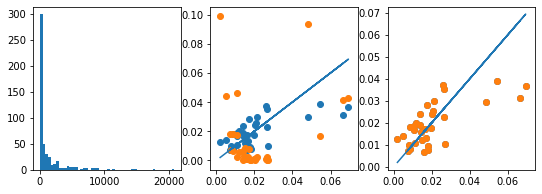

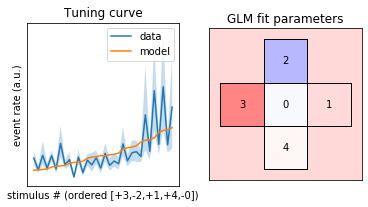

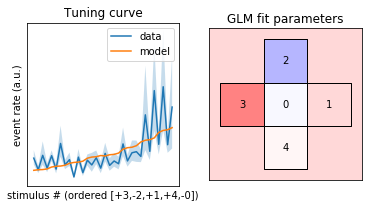

In [97]:
# reload(utils)
# iexpt = 0
# iroi = 60
# lpoisson = 10

# thistheta = thetastar_mt_all[iexpt][iroi][0]
# this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
# thisy = this_bounds[2].copy()

# npt = int(5e2)
# orig_val = utils.evaluate_output_amplitude(thisy,thistheta,fn=utils.f_mt)
# rand_val = np.zeros((npt,))
# to_add = np.zeros((npt,7))
# noise_amplitude = 1e0
# for ipt in range(npt):
#     to_add[ipt] = np.concatenate((noise_amplitude*np.random.randn(5),(0,1)))
#     rand_val[ipt] = utils.evaluate_output_amplitude(thisy,thistheta+to_add[ipt],fn=utils.f_mt)
    
# plt.figure(figsize=(9,3))
# plt.subplot(1,3,1)
# plt.hist(rand_val-orig_val,bins=50)
# plt.subplot(1,3,2)
# plt.plot(thisy,thisy)
# plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt))
# plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta+to_add[np.argmin(rand_val)],fn=utils.f_mt))

# bestthetastar = utils.fit_output_amplitude(thisy,fn=utils.f_mt,theta0=thistheta+to_add[np.argmin(rand_val)],lpoisson=lpoisson) #thistheta+
# for ipt in range(npt):
#     print(ipt)
#     thisthetastar = utils.fit_output_amplitude(thisy,fn=utils.f_mt,theta0=thistheta+to_add[ipt],lpoisson=lpoisson)
#     if thisthetastar[1] < bestthetastar[1]:
#         bestthetastar = thisthetastar
# thisthetastar = bestthetastar

# plt.subplot(1,3,3)
# plt.plot(thisy,thisy)
# plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt))
# plt.scatter(thisy,utils.predict_output_theta_amplitude(thisthetastar[0],fn=utils.f_mt))

# plt.figure(figsize=(6,3))
# show_reordered_plot_and_fit(this_bounds,thistheta)

# plt.figure(figsize=(6,3))
# show_reordered_plot_and_fit(this_bounds,thisthetastar[0],cbd=np.abs(thisthetastar[0]).max())

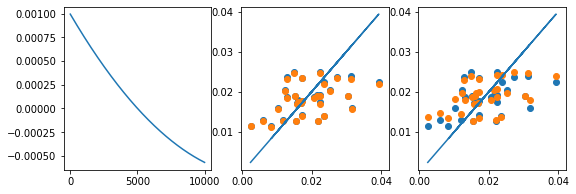

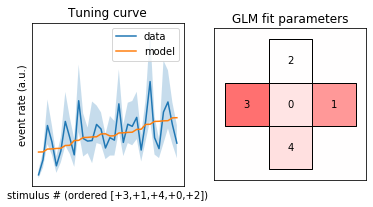

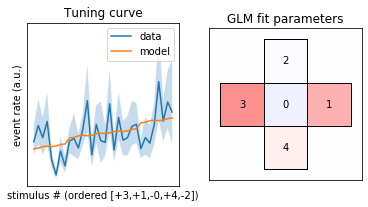

In [81]:
reload(utils)
iexpt = 0
iroi = 1051 # 358

thistheta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
thisy = this_bounds[2].copy()

npt = int(1e4)
orig_val = utils.evaluate_output_amplitude(thisy,thistheta,fn=utils.f_mt)
rand_val = np.zeros((npt,))
#to_add = np.zeros((npt,7))
noise_amplitude = np.linspace(-10,10,npt)
#for ipt in range(npt):
#    to_add[ipt] = np.concatenate((noise_amplitude*np.random.randn(5),np.zeros((2,))))
#    rand_val[ipt] = utils.evaluate_output_amplitude(thisy,thistheta+to_add[ipt],fn=utils.f_mt)
    
yres = thisy - utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt)
nubres = np.sum(yres[:,np.newaxis]*utils.nubs_active,axis=0)
#nubres = np.array((0,1,0,0,0))
to_add = np.zeros((npt,7))
for ipt in range(npt):
    to_add[ipt] = np.concatenate((noise_amplitude[ipt]*nubres,np.zeros((2,))))
    rand_val[ipt] = utils.evaluate_output_amplitude(thisy,thistheta+to_add[ipt],fn=utils.f_mt)
    
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
#plt.hist(rand_val-orig_val,bins=50)
plt.plot(rand_val-orig_val)
plt.subplot(1,3,2)
plt.plot(thisy,thisy)
plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt))
plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta+to_add[0],fn=utils.f_mt)) #np.argmin(rand_val)

thisthetastar = utils.fit_output_amplitude(thisy,fn=utils.f_mt,theta0=thistheta+to_add[0]) #np.argmin(rand_val)

plt.subplot(1,3,3)
plt.plot(thisy,thisy)
plt.scatter(thisy,utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt))
plt.scatter(thisy,utils.predict_output_theta_amplitude(thisthetastar[0],fn=utils.f_mt))

plt.figure(figsize=(6,3))
show_reordered_plot_and_fit(this_bounds,thistheta,cbd=np.abs(thistheta).max())

plt.figure(figsize=(6,3))
show_reordered_plot_and_fit(this_bounds,thisthetastar[0],cbd=np.abs(thisthetastar[0]).max())

In [79]:
(utils.evaluate_output_amplitude(thisy,thistheta,fn=utils.f_mt,lpoisson=lpoisson),utils.evaluate_output_amplitude(thisy,thisthetastar[0],fn=utils.f_mt,lpoisson=lpoisson))

(1.5243716733974138, 1.6315774785005348)

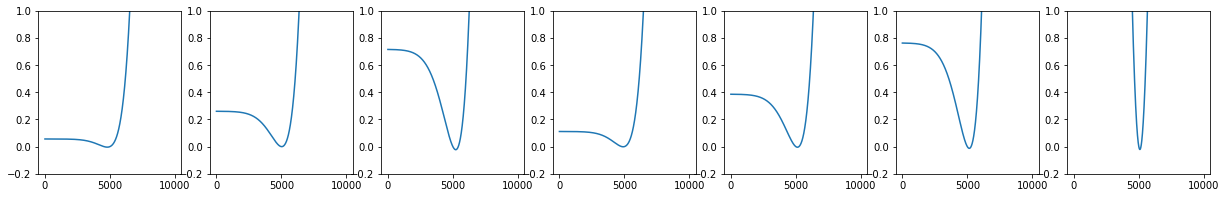

In [53]:
reload(utils)
iexpt = 0
iroi = 396

thistheta = thetastar_mt_all[iexpt][iroi][0]
this_bounds = [bounds[iexpt][ibd][iroi] for ibd in range(3)]
thisy = this_bounds[2].copy()

npt = int(1e4)
orig_val = utils.evaluate_output_amplitude(thisy,thistheta,fn=utils.f_mt)
rand_val = np.zeros((npt,))
#to_add = np.zeros((npt,7))
noise_amplitude = np.linspace(-3,3,npt)
#for ipt in range(npt):
#    to_add[ipt] = np.concatenate((noise_amplitude*np.random.randn(5),np.zeros((2,))))
#    rand_val[ipt] = utils.evaluate_output_amplitude(thisy,thistheta+to_add[ipt],fn=utils.f_mt)
    
#yres = thisy - utils.predict_output_theta_amplitude(thistheta,fn=utils.f_mt)
#nubres = np.sum(yres[:,np.newaxis]*utils.nubs_active,axis=0)
plt.figure(figsize=(21,3))
for inub in range(nnub+2):
    nubres = np.zeros((nnub+2,))
    nubres[inub] = 1
    to_add = np.zeros((npt,nnub+2))
    for ipt in range(npt):
        to_add[ipt] = noise_amplitude[ipt]*nubres
        rand_val[ipt] = utils.evaluate_output_amplitude(thisy,thistheta+to_add[ipt],fn=utils.f_mt)

    plt.subplot(1,nnub+2,inub+1)
    plt.plot(rand_val-orig_val)
    plt.ylim((-0.2,1))

<IPython.core.display.Javascript object>


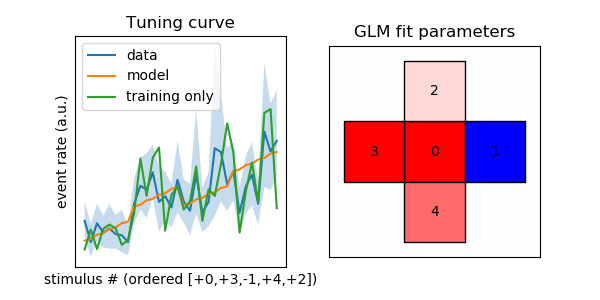

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


759
760
761
762
763
764
765
766
767
768
769
770
771


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
101

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96

/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698


/home/mossing/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583


In [179]:
nnub = 5
plt.figure(figsize=(6,3))
reload(utils)
foldname = 'figures/glm_fits_mt_reordered_train/'
ut.mkdir(foldname)
for iexpt in range(nexpt):
    ut.mkdir(foldname+'expt%d'%iexpt)
    for ind in range(len(thetastar_mt[iexpt])):
        print(ind)
        this_theta = thetastar_mt[iexpt][ind][0]
        flipped = this_theta[:-2] < 0
        nub_ordering = np.argsort(np.abs(this_theta[:-2]))[::-1]
        stim_ordering = reorder_stims(nub_ordering,flipped=flipped)
        #plt.subplot(8,5,ind+1)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.arange(2**nnub),bounds[iexpt][2][ind][stim_ordering],label='data')
        plt.fill_between(np.arange(32),bounds[iexpt][0][ind][stim_ordering],bounds[iexpt][1][ind][stim_ordering],alpha=0.25)
        plt.xticks([])
        plt.yticks([])
        plt.plot(np.arange(2**nnub),predicted_tuning_mt[iexpt][ind][stim_ordering],label='model')
        plt.plot(np.arange(2**nnub),tuning[iexpt][0][ind][stim_ordering],label='training only')
        plt.legend()
        plt.title('Tuning curve')
        plt.ylabel('event rate (a.u.)')
        signs = [] #'' for inub in range(len(flipped))]
        for inub in range(len(nub_ordering)):
            if flipped[nub_ordering[inub]]:
                signs.append('-')
            else:
                signs.append('+')
        markers = ','.join([s+str(n) for s,n in zip(signs,nub_ordering)])
        plt.xlabel('stimulus # (ordered [' + markers + '])')
        plt.subplot(1,2,2)
        utils.show_fit(this_theta)
        plt.title('GLM fit parameters')
        plt.savefig(foldname+'expt%d/roi%04d.pdf'%(iexpt,ind))

In [ ]:
# plt.figure(figsize=(6,3))
# reload(utils)
# ut.mkdir('figures/glm_fits_mt')
# for iexpt in range(nexpt):
#     ut.mkdir('figures/glm_fits_mt/expt%d'%iexpt)
#     for ind in range(theta[iexpt].shape[0]):
#         nub_ordering = np.arange(5) #np.argsort(np.abs(theta[iexpt][ind][:-1]))[::-1]
#         stim_ordering = reorder_stims(nub_ordering)
#         #plt.subplot(8,5,ind+1)
#         plt.clf()
#         plt.subplot(1,2,1)
#         plt.plot(np.arange(32),bounds[iexpt][2][ind][stim_ordering],label='data')
#         plt.fill_between(np.arange(32),bounds[iexpt][0][ind][stim_ordering],bounds[iexpt][1][ind][stim_ordering],alpha=0.25)
#         plt.xticks([])
#         plt.yticks([])
#         plt.plot(np.arange(32),predicted_tuning_mt[iexpt][ind][stim_ordering],label='model')
#         plt.legend()
#         plt.title('Tuning curve')
#         plt.ylabel('event rate (a.u.)')
#         plt.xlabel('stimulus # (ordered ' + str(nub_ordering) + ')')
#         plt.subplot(1,2,2)
#         utils.show_fit(theta[iexpt][ind])
#         plt.title('GLM fit parameters')
#         plt.savefig('figures/glm_fits_mt/expt%d/roi%04d.pdf'%(iexpt,ind))

In [94]:
iexpt = 0
theta[iexpt].shape
lkat = ~(np.isnan(theta[iexpt]).sum(1))
u,s,v = np.linalg.svd(theta[iexpt][lkat])

<IPython.core.display.Javascript object>


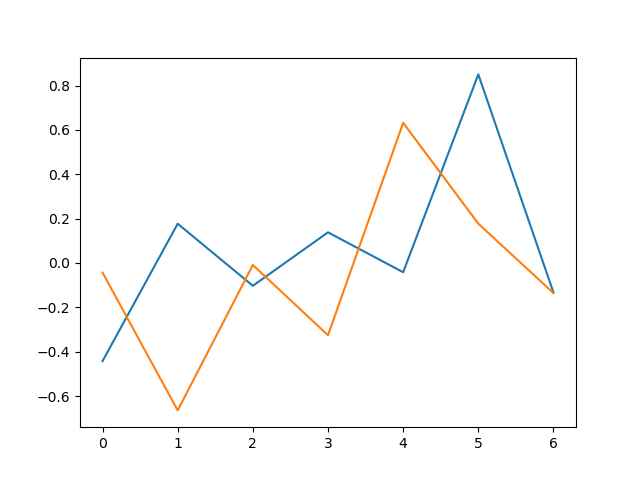

In [100]:
plt.figure()
for i in range(2):
    plt.plot(v[i])

In [98]:
plt.scatter(theta[iexpt][:,-1],theta[iexpt][:,-2],s=1)
plt.ylim((-15,15))
# plt.xlim((-1e5,1e6))

(-15, 15)

<IPython.core.display.Javascript object>


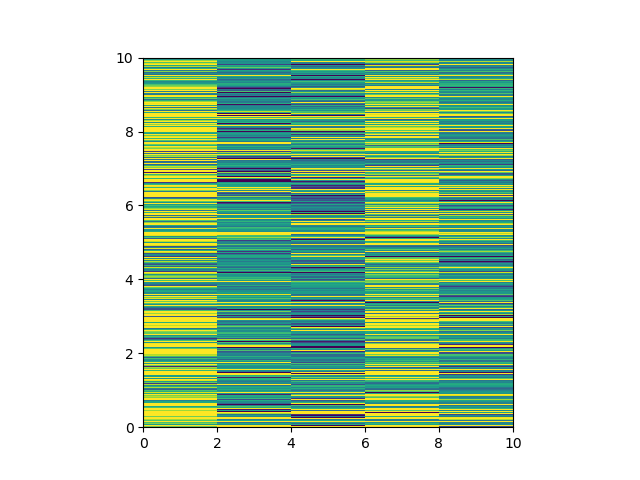

In [106]:
plt.figure()
plt.imshow(theta[0][:,:5],extent=[0,10,0,10],vmin=-1,vmax=1)

<IPython.core.display.Javascript object>


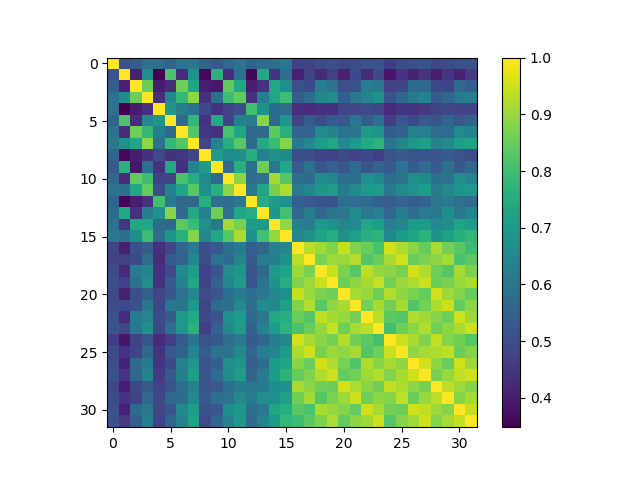

<IPython.core.display.Javascript object>


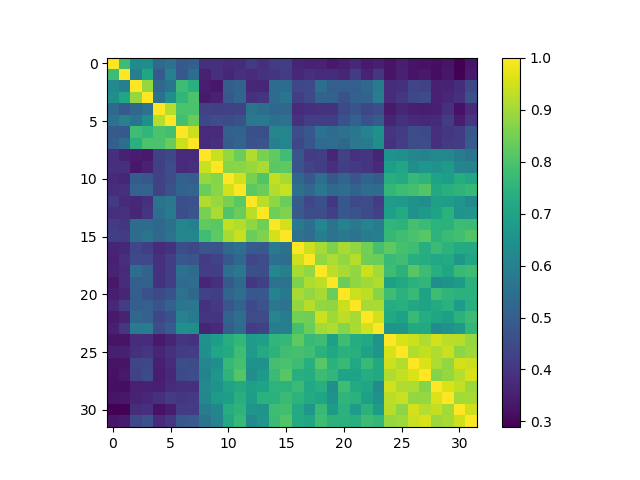

<IPython.core.display.Javascript object>


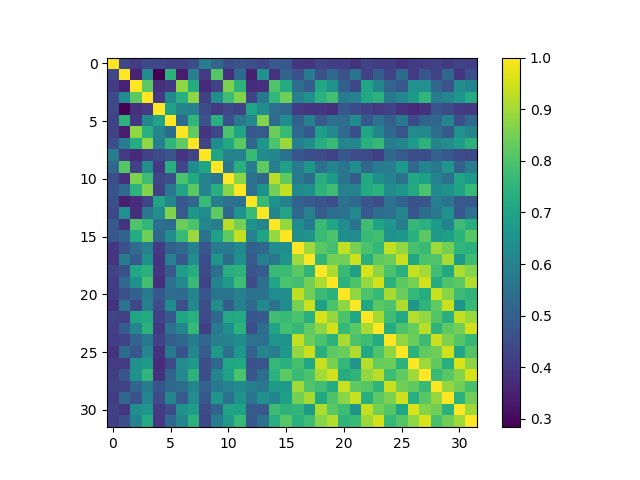

<IPython.core.display.Javascript object>


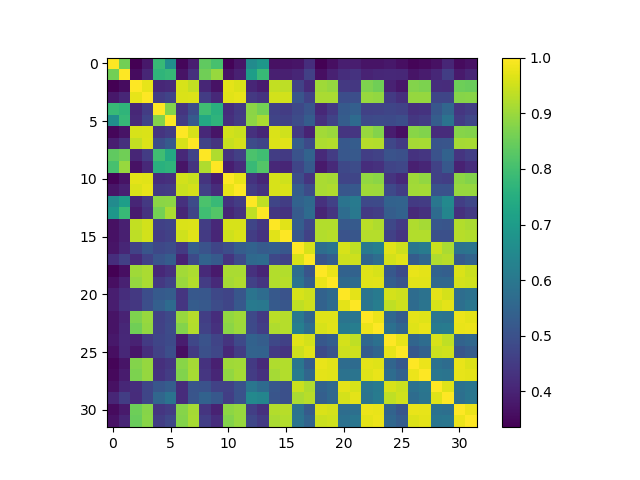

In [114]:
for iexpt in range(4):
    dp = np.zeros((32,32))
    popvec = bounds[iexpt][2]/np.sqrt((bounds[iexpt][2]**2).sum(0))
    for i in range(dp.shape[0]):
        for j in range(dp.shape[1]):
            dp[i,j] = (popvec[:,i]*popvec[:,j]).sum(0)
    plt.figure()
    plt.imshow(dp)
    plt.colorbar()

<IPython.core.display.Javascript object>


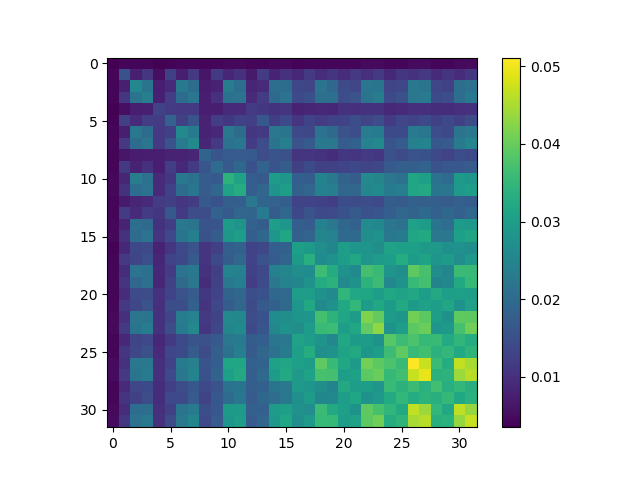

In [139]:
popvec = [None for iexpt in range(nexpt)]
for iexpt in range(nexpt):
    popvec[iexpt] = bounds[iexpt][2]
popvec = np.concatenate(popvec,axis=0)
popvec = popvec/np.sqrt((popvec**2).sum())
dp = np.zeros((32,32))
for i in range(dp.shape[0]):
    for j in range(dp.shape[1]):
        dp[i,j] = (popvec[:,i]*popvec[:,j]).sum(0)
plt.figure()
plt.imshow(dp)
plt.colorbar()

In [140]:
fake_popvec = utils.nubs_active.T
fake_popvec = fake_popvec/(np.sqrt((fake_popvec**2).sum())+1e-4)

In [141]:
fake_dp = np.zeros((32,32))
for i in range(fake_dp.shape[0]):
    for j in range(fake_dp.shape[1]):
        fake_dp[i,j] = (fake_popvec[:,i]*fake_popvec[:,j]).sum(0)

<IPython.core.display.Javascript object>


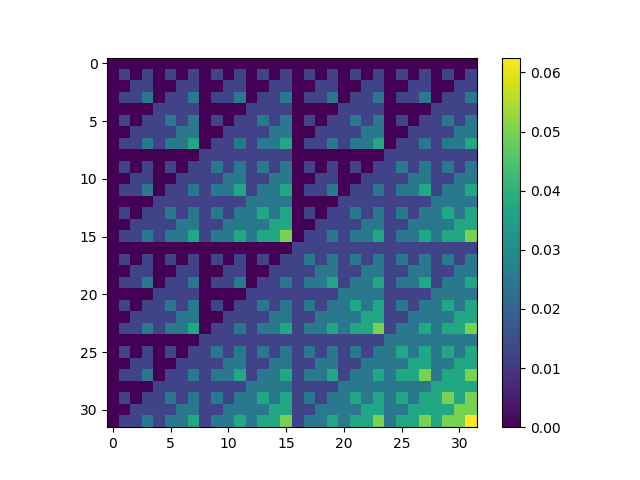

In [142]:
plt.figure()
plt.imshow(fake_dp)
plt.colorbar()

<IPython.core.display.Javascript object>


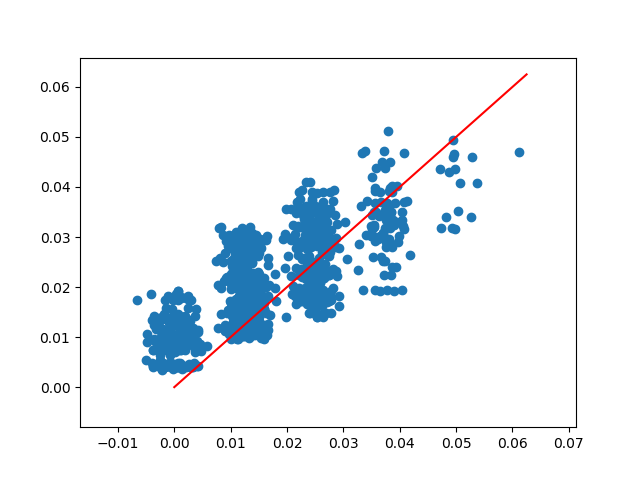

In [149]:
plt.figure()
plt.scatter(fake_dp.flatten()+20e-4*np.random.randn(*(fake_dp.flatten().shape)),dp.flatten())
plt.plot(fake_dp.flatten(),fake_dp.flatten(),c='r')

In [152]:
theta[0].shape

(1519, 7)

<IPython.core.display.Javascript object>


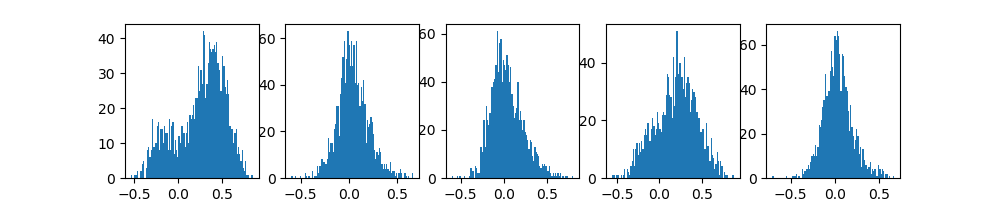

In [162]:
nnub = 5
iexpt = 0
plt.figure(figsize=(10,2))
for inub in range(nnub):
    plt.subplot(1,nnub,inub+1)
    plt.hist(theta[iexpt][:,inub]/np.abs(theta[iexpt][:,:5]).sum(1),bins=100)

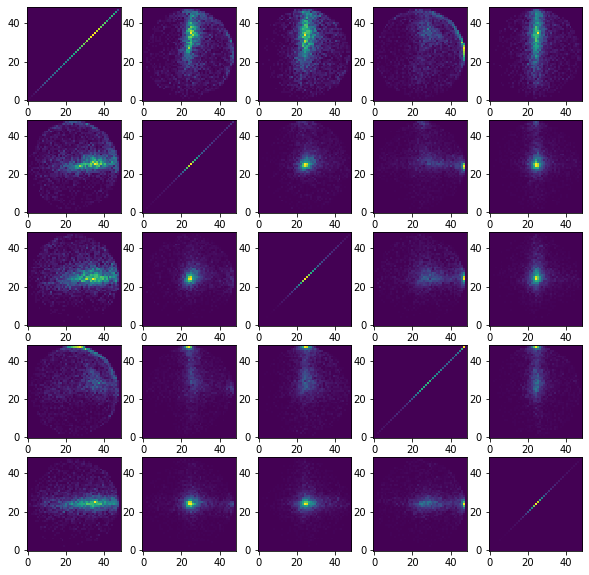

In [46]:
iexpt = 0
thetanorm = theta[iexpt][:,:nnub]/np.abs(theta[iexpt][:,:nnub]).sum(1)[:,np.newaxis]
for iexpt in range(1,nexpt):
    newthetanorm = theta[iexpt][:,:nnub]/np.sqrt((np.abs(theta[iexpt][:,:nnub])**2).sum(1))[:,np.newaxis]
    thetanorm = np.concatenate((thetanorm,newthetanorm),axis=0)
    
plt.figure(figsize=(10,10))
for inub1 in range(nnub):
    vi = thetanorm[:,inub1]
    for inub2 in range(nnub):
        vj = thetanorm[:,inub2]
        lkat = ~np.isnan(vi) & ~np.isnan(vj)
        plt.subplot(nnub,nnub,nnub*inub1+inub2+1)
        h,_,_ = np.histogram2d(vi[lkat],vj[lkat],bins=np.linspace(-1.05,1.05,50))
        plt.imshow(h,origin='lower')

In [165]:
vi.min()

nan